## Documentation and Summary
- Multivariate input and output: Using x_{1,2,...,T} and y_{1, 2,…, T-1} to predict y_T (4 dimensions to 1 dimension)
- The data is normalized before training and testing
- I have experimented different hyperparameters and the selected values here is: hidden states =20, lstm layer (stacked)= 1, batch size = 16, timestep = 100, learning rate = 0.001
- Outstanding problem:  NA
- Loss function (and also used as metrics here): MSE or MLE



### LSTM

In [1]:
import random
import numpy as np
import torch
import pandas as pd
# multivariate data preparation
from numpy import array
from numpy import hstack


In [2]:
import matplotlib.pyplot as plt

## Data Prepration: Visualize Data and Delete the date column

In [3]:
df = pd.read_csv("/content/bitcoin_yahoo.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.049510,0.049510,0.049510,0.049510,0.049510,0
1,2010-07-17,0.049510,0.085850,0.059410,0.085840,0.085840,5
2,2010-07-18,0.085840,0.093070,0.077230,0.080800,0.080800,49
3,2010-07-19,0.080800,0.081810,0.074260,0.074740,0.074740,20
4,2010-07-20,0.074740,0.079210,0.066340,0.079210,0.079210,42
...,...,...,...,...,...,...,...
3196,2019-04-16,5212.810059,5270.759766,5190.810059,5236.259766,5236.259766,194699629
3197,2019-04-17,5236.259766,5317.779785,5232.990234,5289.750000,5289.750000,187312150
3198,2019-04-18,5289.750000,5353.009766,5212.180176,5295.529785,5295.529785,158699049
3199,2019-04-19,5295.529785,5366.600098,5274.450195,5326.180176,5326.180176,123577001


In [4]:
del df['Date']

In [5]:
df_train = df[:int(0.9*len(df))]
df_valid = df[int(0.9*len(df)):int(0.95*len(df))]
df_test = df[int(0.95*len(df)):]


In [6]:
df_train

,Open,High,Low,Close,Adj Close,Volume
0,0.049510,0.049510,0.049510,0.049510,0.049510,0
1,0.049510,0.085850,0.059410,0.085840,0.085840,5
2,0.085840,0.093070,0.077230,0.080800,0.080800,49
3,0.080800,0.081810,0.074260,0.074740,0.074740,20
4,0.074740,0.079210,0.066340,0.079210,0.079210,42
...,...,...,...,...,...,...
2875,7393.020020,7608.870117,7349.520020,7502.149902,7502.149902,458223966
2876,7501.740234,7614.660156,7370.270020,7530.549805,7530.549805,458687659
2877,7530.549805,7697.339844,7467.790039,7643.259766,7643.259766,362414878
2878,7643.259766,7774.959961,7606.759766,7719.750000,7719.750000,332313005


In [7]:
df_valid

,Open,High,Low,Close,Adj Close,Volume
2880,7503.319824,7672.700195,7394.970215,7629.399902,7629.399902,440337235
2881,7629.399902,7701.350098,7504.979980,7661.790039,7661.790039,396116252
2882,7661.790039,7755.919922,7651.129883,7700.109863,7700.109863,342475552
2883,7700.399902,7709.609863,7559.500000,7627.520020,7627.520020,310119047
2884,7627.560059,7691.740234,7495.720215,7513.689941,7513.689941,218013881
...,...,...,...,...,...,...
3035,6479.720215,6562.790039,6476.589844,6529.680176,6529.680176,360052788
3036,6530.939941,6542.419922,6438.270020,6446.060059,6446.060059,273205386
3037,6446.060059,6457.970215,6352.450195,6377.990234,6377.990234,237893036
3038,6377.990234,6419.919922,6376.169922,6396.370117,6396.370117,94313328


In [8]:
df_test

,Open,High,Low,Close,Adj Close,Volume
3040,6408.180176,6435.410156,6350.870117,6375.080078,6375.080078,181575610
3041,6375.080078,6389.430176,6315.580078,6339.169922,6339.169922,227689745
3042,6339.169922,6375.700195,5469.930176,5741.470215,5741.470215,1045469380
3043,5740.509766,5767.060059,5300.750000,5647.500000,5647.500000,820864013
3044,5647.500000,5676.540039,5487.870117,5586.270020,5586.270020,397196182
...,...,...,...,...,...,...
3196,5212.810059,5270.759766,5190.810059,5236.259766,5236.259766,194699629
3197,5236.259766,5317.779785,5232.990234,5289.750000,5289.750000,187312150
3198,5289.750000,5353.009766,5212.180176,5295.529785,5295.529785,158699049
3199,5295.529785,5366.600098,5274.450195,5326.180176,5326.180176,123577001


In [9]:
# sq_train = df_train.to_numpy()
# sq_test = df_test.to_numpy()
# sq_valid = df_valid.to_numpy()
sq = df.to_numpy()

In [10]:
def split_sequences(seq, n_steps):
    X, y = [], []
    for i in range(len(seq) - n_steps - 1):
        seq_x, seq_y = seq[i:(i + n_steps), :], seq[i + n_steps, 3]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [11]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 32 # number of hidden state's features
        self.n_layers = 1 # number of LSTM layers (stacked)
        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 1)
        
    
    def init_hidden(self, batch_size):
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).cuda()
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).cuda()
        self.hidden = (hidden_state, cell_state)
    
    
    def forward(self, x):  
        #x = torch.from_numpy(x)      
        batch_size, seq_len, _  = x.size()
        
        lstm_out, self.hidden = self.l_lstm(x, self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.l_linear(x)

In [12]:
n_features = 6 # this is number of parallel inputs
n_timesteps = 30 # this is number of timesteps

# convert dataset into input/output
X, y = split_sequences(sq, n_timesteps)
# X_train, y_train = split_sequences(sq_train, n_timesteps)
# X_valid, y_valid = split_sequences(sq_valid, n_timesteps)
# X_test, y_test = split_sequences(sq_test, n_timesteps)

# define the proportion of data to allocate to train, validation, and test sets
train_prop = 0.85
# val_prop = 0.15
# test_prop = 0.15

# shuffle the indices of X and y
indices = np.random.permutation(len(X))

# calculate the number of samples for each set based on the proportions
train_size = int(train_prop * len(X))
# val_size = int(val_prop * len(X))
# test_size = len(X) - train_size - val_size

# divide the shuffled indices into train, validation, and test sets
train_indices = indices[:train_size]
val_indices = indices[train_size:]
# val_indices = indices[train_size:train_size+val_size]
##test_indices = indices[train_size+val_size:]

# create the train, validation, and test sets from the shuffled indices
X_train = X[train_indices]
y_train = y[train_indices]
X_valid = X[val_indices]
y_valid = y[val_indices]
# X_test = X[test_indices]
# y_test = y[test_indices]
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
# print(X_test.shape, y_test.shape)

# create NN
mv_net = MV_LSTM(n_features,n_timesteps)
criterion = torch.nn.MSELoss(reduction='mean') # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=0.001)

train_episodes = 1500
batch_size = 128

(2694, 30, 6) (2694,)
(476, 30, 6) (476,)


In [13]:
# use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mv_net.to(device)
print(device)

cuda


In [14]:
mv_net.train()
best_loss = 10000000
loss_plot = []
val_loss_plot = []
for t in range(train_episodes):
    step_loss = 0
    for b in range(0, len(X_train), batch_size):
        if b + batch_size > len(X_train):
            break
        inpt = X_train[
            b : b + batch_size, :, :
        ]  # /np.linalg.norm(X_train[b:b+batch_size,:,:])
        target = y_train[
            b : b + batch_size
        ]  # /np.linalg.norm(y_train[b:b+batch_size])
        if target.shape[0] != 0:
            x_batch = (
                torch.from_numpy(inpt).float().to(device)
            )  # torch.tensor(inpt,dtype=torch.float32)
            y_batch = torch.from_numpy(
                target
            ).float()  # torch.tensor(target,dtype=torch.float32)
            mv_net.init_hidden(x_batch.size(0))
            output = mv_net(x_batch)
            loss = criterion(output.cpu().view(-1), np.transpose(y_batch))
            # infect_dist = torch.distributions.normal.Normal(y_batch, 0.1)
            # loss = -infect_dist.log_prob(output.squeeze().cpu()).mean()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            step_loss += loss.item()

    # validation
    val_loss = 0
    with torch.no_grad():
        for b in range(0, len(X_valid), batch_size):
            if b + batch_size > len(X_valid):
                break
            test_seq = X_valid[b : b + batch_size, :, :]  
            label_seq = y_valid[
                b : b + batch_size
            ]  
            x_batch = torch.from_numpy(test_seq).float().to(device)
            y_batch = torch.from_numpy(label_seq).float()
            mv_net.init_hidden(x_batch.size(0))
            try:
                output = mv_net(x_batch)
                batch_val_loss = criterion(output.cpu().view(-1), np.transpose(y_batch))
                infect_dist = torch.distributions.normal.Normal(y_batch, 0.1)
                # batch_val_loss = -infect_dist.log_prob(
                #     output.squeeze().cpu()
                # ).mean()
                val_loss += batch_val_loss.item()
            except:
                continue
                
    num_batches_train = len(X_train) // batch_size
    num_batches_test = len(X_valid) // batch_size
    train_loss = step_loss / num_batches_train
    valid_loss = val_loss / num_batches_test
    loss_plot.append(train_loss)
    val_loss_plot.append(valid_loss)
    if valid_loss < best_loss:
        torch.save(mv_net.state_dict(), '/content/mse_lstm_state_dict_model.pt')
        best_loss = valid_loss

    print("step : ", t, "training loss : ", train_loss)
    print("step : ", t, "validation loss : ", valid_loss)

step :  0 training loss :  11659329.095238095
step :  0 validation loss :  9717971.666666666
step :  1 training loss :  11657648.761904761
step :  1 validation loss :  9719035.666666666
step :  2 training loss :  11653668.30952381
step :  2 validation loss :  9712515.0
step :  3 training loss :  11647339.595238095
step :  3 validation loss :  9715098.833333334
step :  4 training loss :  11645212.476190476
step :  4 validation loss :  9708040.166666666
step :  5 training loss :  11650339.547619049
step :  5 validation loss :  9714720.666666666
step :  6 training loss :  11639151.333333334
step :  6 validation loss :  9691226.166666666
step :  7 training loss :  11623914.88095238
step :  7 validation loss :  9684519.333333334
step :  8 training loss :  11645538.38095238
step :  8 validation loss :  9712780.666666666
step :  9 training loss :  11646389.69047619
step :  9 validation loss :  9722905.833333334
step :  10 training loss :  11654815.214285715
step :  10 validation loss :  97114

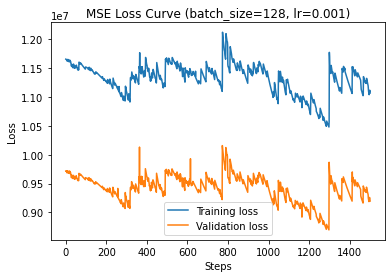

In [15]:
# Visualize training loss
updates = [i for i in range(1, len(loss_plot) + 1)]
plt.plot(updates, loss_plot, label="Training loss")
plt.plot(updates, val_loss_plot, label="Validation loss")
plt.title("MSE Loss Curve (batch_size=128, lr=0.001)")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
# mv_net = MV_NET(n_features,n_timesteps)
# mv_net.load_state_dict(torch.load('/content/mle_lstm_state_dict_model.pt'))

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# mv_net.to(device)



# preds = []
# labels = []
# losses = []
# running_loss = 0

# for j in range(0, 250*21, 250):
#     X_trapolate = X_test[j+100:j+250]
#     test_seq = X_test[j:j+1]
#     pred = []
#     label = []
#     with torch.no_grad():
#         for i in range(150):
#             x_batch = torch.from_numpy(test_seq).float().to(device)
#             mv_net.init_hidden(x_batch.size(0))
#             output = mv_net(x_batch)
#             t = output.cpu().view(-1).numpy()[0]
#             # Produce output of the extrapolation
#             pred.append(t)
#             # import pdb; pdb.set_trace()
#             label.append(X_trapolate[i][0][3])
#             # Update test seq
#             np_to_add = X_trapolate[i][0]
#             np_to_add[-1] = t
#             arr = test_seq.tolist()
#             del arr[0][0]
#             arr[0].append(np_to_add)
#             test_seq = np.array(arr)
#     infect_dist = torch.distributions.normal.Normal(torch.FloatTensor(label), 0.1)
#     loss = -infect_dist.log_prob(torch.FloatTensor(pred).squeeze()).mean()
#     running_loss += loss.item()
#     #loss = mean_squared_error(pred, label)
#     #running_loss += loss
#     losses.append(loss)
#     preds.append(pred)
#     labels.append(label)
        

In [17]:
# Visualize preds vs labels
for j in range(21):
  pred = preds[j]
  label = labels[j]
  updates = [i for i in range(1, 151)]
  plt.figure(figsize=(20, 10))
  plt.plot(updates, pred, label="Prediction")
  plt.plot(updates, label, label="Groud Truth")
  plt.title("Prediction vs Groud Truth (MLE extrapolated)")
  plt.xlabel("Steps")
  plt.ylabel("num_infect")
  plt.legend()
  plt.show()
  #plt.savefig('')

NameError: ignored

In [ ]:
# # Visualize preds vs labels
# updates = [i for i in range(1, len(preds) + 1)]
# plt.figure(figsize=(20, 10))
# plt.plot(updates, preds[:200], label="Prediction")
# plt.plot(updates[:200], labels[:200], label="Groud Truth")
# plt.title("Prediction vs Groud Truth (first 200 timesteps)")
# plt.xlabel("Steps")
# plt.ylabel("Closed Price (USD)")
# plt.legend()
# plt.show()